In [149]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [194]:
corpus = pd.read_json("corpus_mod.json")

In [195]:
X = corpus['review_processed']
y = corpus['sentiment_label']

In [196]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=0
)

In [197]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    random_state=0
)

In [198]:
sets = {"X_train": X_train,"y_train": y_train,"X_val": X_val,
    "y_val": y_val,"X_test": X_test,"y_test": y_test}

for name, set_ in sets.items():
    print(f"Number of rows in {name}: {set_.shape[0]}")

Number of rows in X_train: 7803
Number of rows in y_train: 7803
Number of rows in X_val: 1377
Number of rows in y_val: 1377
Number of rows in X_test: 1620
Number of rows in y_test: 1620


In [199]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [200]:
cv = TfidfVectorizer(
    ngram_range=(1, 3),  # Includes unigrams, bigrams, and trigrams
    max_df=0.9,          # Filters terms appearing in +90% of the reviews
    min_df=10            # Filters very rare terms, appearing in fewer than 10 documents
)

In [201]:
cv.fit(X_train)

TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1, 3))

In [202]:
feature_names = cv.get_feature_names_out()
print(f"Vocabulary size (Number of features): {len(feature_names)}")

Vocabulary size (Number of features): 2892


In [203]:
X_train_tfidf = cv.fit_transform(X_train)
X_test_tfidf = cv.transform(X_test)

In [204]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=1000)
    lr.fit(X_train_tfidf, y_train)

    train_predict = lr.predict(X_train_tfidf)
    test_predict = lr.predict(X_test_tfidf)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.7481481481481481
Accuracy for C=0.05: 0.7709876543209877
Accuracy for C=0.25: 0.8012345679012346
Accuracy for C=0.5: 0.8067901234567901
Accuracy for C=1: 0.8111111111111111
Accuracy for C=10: 0.8111111111111111
Accuracy for C=100: 0.782716049382716
Accuracy for C=1000: 0.7580246913580246
Accuracy for C=10000: 0.7506172839506173


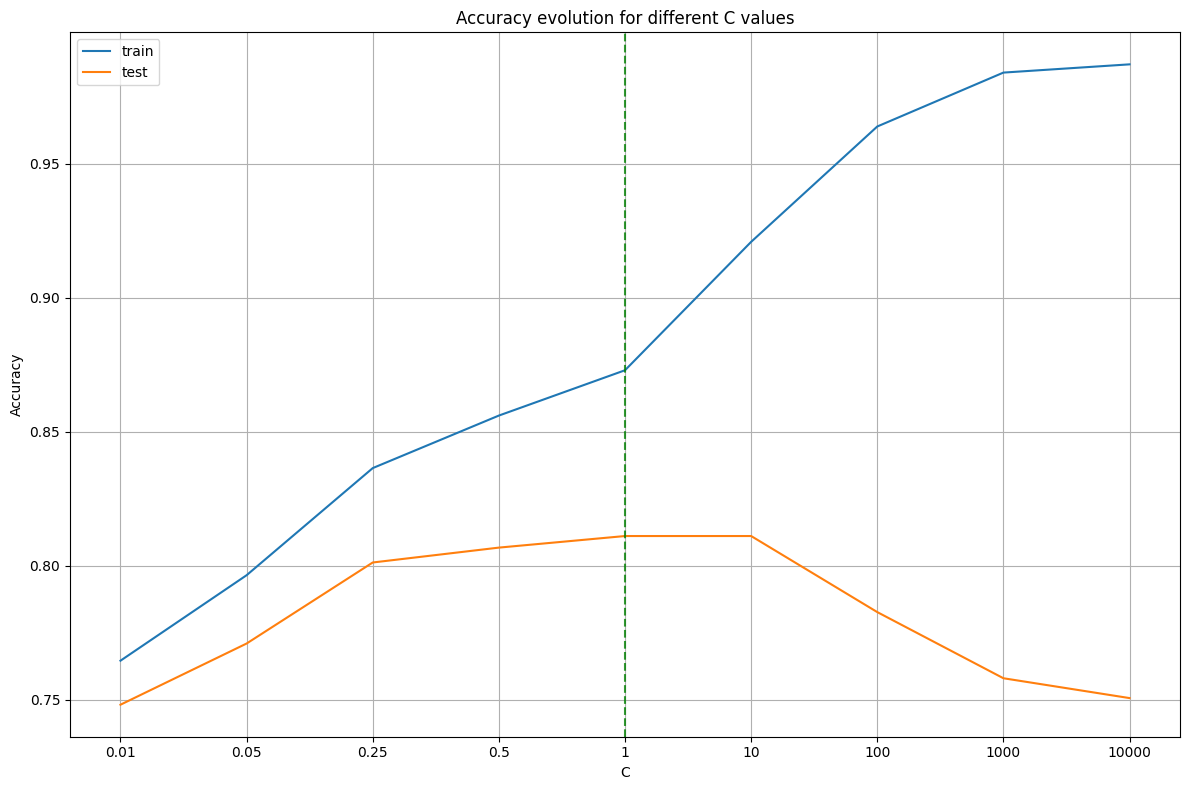

In [205]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [206]:
lr_model = LogisticRegression(C=1, max_iter=1000, random_state=0)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

In [207]:
print("\n=============================================")
print("### 1. Regresión Logística (TF-IDF) ###")
print("=============================================")
print('\nConfussion matrix:\n{}'.format(confusion_matrix(y_test, y_pred_lr)))
print(f"\nAccuracy (Exactitud): {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred_lr))


### 1. Regresión Logística (TF-IDF) ###

Confussion matrix:
[[679 149]
 [157 635]]

Accuracy (Exactitud): 0.8111

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.81      0.82      0.82       828
           1       0.81      0.80      0.81       792

    accuracy                           0.81      1620
   macro avg       0.81      0.81      0.81      1620
weighted avg       0.81      0.81      0.81      1620



In [208]:
mnb_model = MultinomialNB()
mnb_model.fit(X_train_tfidf, y_train)
y_pred_mnb = mnb_model.predict(X_test_tfidf)

In [209]:
print("\n=============================================")
print("### 2. Naive Bayes Multinomial (TF-IDF) ###")
print("=============================================")
print('\nConfussion matrix:\n{}'.format(confusion_matrix(y_test, y_pred_mnb)))
print(f"\nAccuracy (Exactitud): {accuracy_score(y_test, y_pred_mnb):.4f}")
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred_mnb))


### 2. Naive Bayes Multinomial (TF-IDF) ###

Confussion matrix:
[[661 167]
 [167 625]]

Accuracy (Exactitud): 0.7938

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80       828
           1       0.79      0.79      0.79       792

    accuracy                           0.79      1620
   macro avg       0.79      0.79      0.79      1620
weighted avg       0.79      0.79      0.79      1620



DEEP LEARNING

In [210]:
!pip install gensim

from gensim.models import Word2Vec
import multiprocessing

In [211]:
cores = multiprocessing.cpu_count()
print (cores)

2


In [212]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    min_count=20,        # Eliminates low-frequency words (less than 20 occurrences)
    window=2,            # Small context window (2 words on either side)
    vector_size=64,
    sample=6e-5,         # Low threshold for subsampling high-frequency words
    alpha=0.03,          # Initial learning rate, allowing for large weight adjustments at the start of training.
    min_alpha=0.0007,    # Minimum learning rate, ensuring fine, stable weight adjustments toward convergence in later epochs.
    negative=20,         # Provides enough noise examples for the model to accurately distinguish relevant context.
    workers=cores-1,
    seed=0
)

In [213]:
sent = [row.split() for row in X]
w2v_model.build_vocab(sent, progress_per=10000)

In [214]:
print('Vocabulary size: {} words'.format(len(w2v_model.wv.key_to_index)))

Vocabulary size: 1724 words


In [215]:
w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(2431275, 7808280)

In [216]:
max = 0
mean = []
for review in X:
  length = len(review)
  mean.append(len(review))
  if length > max:
    max = length

In [217]:
sum(mean) / len(mean)

147.35787037037036

In [218]:
max

4784

In [219]:
from tensorflow.keras.preprocessing.text import Tokenizer

def generate_tokenizer(train_df):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df)
    vocab_size = len(tokenizer.word_index) + 1
    print(f"Total words: {vocab_size}")
    return tokenizer, vocab_size

In [220]:
X_train_words = pd.DataFrame(X_train, columns=["review_processed"])
X_test_words = pd.DataFrame(X_test, columns=["review_processed"])
X_val_words = pd.DataFrame(X_val, columns=["review_processed"])

In [221]:
tokenizer, vocabulary_size = generate_tokenizer(X_train_words.review_processed)

Total words: 9871


In [222]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

max_words = 400

X_train_words = pad_sequences(tokenizer.texts_to_sequences(X_train_words.review_processed), maxlen=max_words)
X_test_words = pad_sequences(tokenizer.texts_to_sequences(X_test_words.review_processed), maxlen=max_words)
X_val_words = pad_sequences(tokenizer.texts_to_sequences(X_val_words.review_processed), maxlen=max_words)

print("✅ Padding completado. Datos listos para el entrenamiento.")
print(f"La forma de X_train es: {X_train_words.shape}")
print(f"La forma de X_test es: {X_test_words.shape}")
print(f"La forma de X_val es: {X_val_words.shape}")

✅ Padding completado. Datos listos para el entrenamiento.
La forma de X_train es: (7803, 400)
La forma de X_test es: (1620, 400)
La forma de X_val es: (1377, 400)


In [223]:
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout

In [256]:
embedding_size = 64

Embedding_layer = Embedding(
    input_dim=vocabulary_size,
    output_dim=embedding_size,
    input_length=max_words)

In [257]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN

batch_size = 64
num_epochs = 2

In [258]:
model = Sequential()
model.add(Embedding_layer)
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [259]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [260]:
H = model.fit(X_train_words, y_train,
          validation_data=(X_val_words, y_val),
          batch_size=batch_size, epochs=3)

Epoch 1/3
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6022 - loss: 0.6551 - val_accuracy: 0.7807 - val_loss: 0.4797
Epoch 2/3
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8179 - loss: 0.4226 - val_accuracy: 0.7945 - val_loss: 0.4404
Epoch 3/3
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8831 - loss: 0.2891 - val_accuracy: 0.7959 - val_loss: 0.5110


In [261]:
scores = model.evaluate(X_test_words, y_test, verbose=0)
print("Test accuracy:", scores[1])

Test accuracy: 0.7919753193855286


In [262]:
model_gru = Sequential()
model_gru.add(Embedding_layer)
model_gru.add(GRU(32))

model_gru.add(Dense(1, activation='sigmoid'))

print(model_gru.summary())

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 400, 64)        │       631,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_15 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 631,744 (2.41 MB)

 Trainable params: 631,744 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

None


In [263]:
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [264]:
model_gru.fit(X_train_words, y_train,
          validation_data=(X_val_words, y_val),
          batch_size=batch_size, epochs=3)

Epoch 1/3
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7678 - loss: 0.5384 - val_accuracy: 0.8010 - val_loss: 0.5039
Epoch 2/3
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9038 - loss: 0.2431 - val_accuracy: 0.7967 - val_loss: 0.5643
Epoch 3/3
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9350 - loss: 0.1789 - val_accuracy: 0.7858 - val_loss: 0.6745


In [265]:
scores = model_gru.evaluate(X_test_words, y_test, verbose=0)
print("Test accuracy:", scores[1])

Test accuracy: 0.7932098507881165


In [266]:
model_rnn = Sequential()
model_rnn.add(Embedding_layer)
model_rnn.add(SimpleRNN(32))

model_rnn.add(Dense(1, activation='sigmoid'))

print(model_rnn.summary())

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 400, 64)        │       631,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 631,744 (2.41 MB)

 Trainable params: 631,744 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

None


In [267]:
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [269]:
model_rnn.fit(X_train_words, y_train,
          validation_data=(X_val_words, y_val),
          batch_size=batch_size, epochs=3)

Epoch 1/3
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.7157 - loss: 0.5256 - val_accuracy: 0.7821 - val_loss: 0.6054
Epoch 2/3
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9214 - loss: 0.2061 - val_accuracy: 0.7887 - val_loss: 0.6338
Epoch 3/3
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9442 - loss: 0.1602 - val_accuracy: 0.7807 - val_loss: 0.6060


In [270]:
scores = model_rnn.evaluate(X_test_words, y_test, verbose=0)
print("Test accuracy:", scores[1])

Test accuracy: 0.7641975283622742




---



---



---



#Hugging face model

In [271]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
!pip install evaluate
import evaluate


MODEL_NAME = "MoritzLaurer/MiniLM-L6-mnli-binary"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

In [272]:
train_df = pd.DataFrame({'review_processed': X_train, 'label': y_train})
val_df = pd.DataFrame({'review_processed': X_val, 'label': y_val})
test_df = pd.DataFrame({'review_processed': X_test, 'label': y_test})

raw_datasets = DatasetDict({
    'train': Dataset.from_pandas(train_df, preserve_index=False),
    'validation': Dataset.from_pandas(val_df, preserve_index=False),
    'test': Dataset.from_pandas(test_df, preserve_index=False)
})

MAX_LENGTH = 512

In [273]:
def tokenize_function(examples):

    return tokenizer(examples["review_processed"], truncation=True, padding="max_length", max_length=MAX_LENGTH)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
print("✅ Tokenización completada.")

Map:   0%|          | 0/7803 [00:00<?, ? examples/s]

Map:   0%|          | 0/1377 [00:00<?, ? examples/s]

Map:   0%|          | 0/1620 [00:00<?, ? examples/s]

✅ Tokenización completada.


In [274]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):

    logits, labels = eval_pred

    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [277]:
training_args = TrainingArguments(
    num_train_epochs=5,
    learning_rate=2e-05,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_ratio=0.1,
    weight_decay=0.06,
    fp16=True)

In [278]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

test_results = trainer.evaluate(tokenized_datasets["test"])
print("\nTest results (Accuracy):")
print(f"{test_results['eval_accuracy']:.4f}")

/tmp/ipython-input-3353974941.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.464700
1000,0.344200



Test results (Accuracy):
0.8086


In [279]:
val_results = trainer.evaluate(tokenized_datasets["validation"])
print("\nValidation results (Accuracy):")
print(f"{val_results['eval_accuracy']:.4f}")


Validation results (Accuracy):
0.8061


In [280]:
train_results = trainer.evaluate(tokenized_datasets["train"])
print("\nTrain results (Accuracy):")
print(f"{train_results['eval_accuracy']:.4f}")


Train results (Accuracy):
0.9022


####**Comments and conclusions**

Logistic Regression achieved the highest score in the entire project at 81.11%. This demonstrates that the combination of TF-IDF and Logistic Regression remains highly effective.

Training results for these models showed a huge disparity between training accuracy and validation accuracy, causing overfitting, confirming that recurrent architectures tend to memorize the training data quickly because since epoch 2, training acc outperforms validation. Despite implementing advanced regularization techniques (Dropout, L2, LayerNormalization) and reducing the number of neurons in the model, results were quite the same.

I decided to implement a Transformer from HuggingFace, achieving an 80.86% accuracy on test and 90% on train, showing again overfitting.

In [286]:
print("1. Regresión Logística")
print('\nConfussion matrix:\n{}'.format(confusion_matrix(y_test, y_pred_lr)))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nClassification report:\n\n", classification_report(y_test, y_pred_lr))

1. Regresión Logística

Confussion matrix:
[[679 149]
 [157 635]]

Accuracy: 0.8111

Classification report:

               precision    recall  f1-score   support

           0       0.81      0.82      0.82       828
           1       0.81      0.80      0.81       792

    accuracy                           0.81      1620
   macro avg       0.81      0.81      0.81      1620
weighted avg       0.81      0.81      0.81      1620

